# Final Project - Gold Forecasting

## Problem Statement

The primary objective of this project is to develop a robust forecasting model for gold prices using multiple time series analysis. By integrating a variety of economic indicators and global event data, the model aims to capture the complex dynamics that influence gold prices. Specifically, the project will evaluate how well variables such as the Federal Funds Effective Rate, U.S., the S&P 500 index, and crude oil prices (WTI) correlate with and predict the fluctuations in gold prices. The success of the model will be measured based on its accuracy and reliability in forecasting future gold price movements, thereby providing valuable insights for investors, economists, and policymakers.

*In this project we will explore the data in monthly format, if the data was originally in daily format, we will transform the data and use Month-End Value.*

## Assumptions/Hypotheses about Data and/or Modeling

### Assumptions:

Data Completeness and Quality: We assume that the data collected from reputable sources such as the World Gold Council, FRED, and others are accurate, complete, and free from significant errors.

Stationarity: For effective time series analysis, we often assume that the data are stationary, or have been transformed to be stationary. This means that the statistical properties such as mean, variance, and autocorrelation are constant over time. Non-stationary data will require differencing or transformation to achieve stationarity.

Independence of Errors: It is assumed that the forecast errors are independent and normally distributed with a mean of zero and constant variance, which is a common assumption in time series forecasting.

### Hypotheses:

Interest Rates Impact: The Federal Funds Effective Rate is hypothesized to be inversely related to gold prices. As interest rates rise, the opportunity cost of holding non-yielding assets like gold increases, potentially lowering gold prices.

Economic Uncertainty and Recession: During periods of economic uncertainty or recessions, gold is traditionally viewed as a safe haven. Thus, we hypothesize that indicators of economic downturns, such as the U.S. recession indicators, are positively correlated with increases in gold prices.

Stock Market Relationships: The relationship between the S&P 500 and gold prices is assumed to be generally inverse; as stocks offer higher returns, gold becomes less attractive, and vice versa.

Oil Prices as an Economic Indicator: Since crude oil prices are a significant economic indicator affecting inflation and economic growth, they might also influence gold prices. The hypothesis is that higher oil prices, indicating higher inflation, could increase the demand for gold as a hedge against inflation.

In [237]:
!pip3 install pmdarima

In [238]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import seaborn as sns
sns.set()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

## Data properties (stationarity, correlations, data distribution) and Exploratory data analysis

In [239]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [240]:
%cd /content/drive/My Drive/Time Series Final Project/

/content/drive/My Drive/Time Series Final Project


In [241]:
gold_price = pd.read_excel("gold_price.xlsx")
gold_price['Date'] = gold_price['Date'].dt.strftime('%Y-%m-%d') # make sure the time series
gold_price.head()

,Date,Price
0,1978-01-31,207.83
1,1978-02-28,227.27
2,1978-03-31,245.67
3,1978-04-28,242.05
4,1978-05-31,239.16


In [242]:
fed_funds_rate = pd.read_excel("fed_funds_rate.xls")
# Transform the dataset
fed_funds_rate['observation_date'] = pd.to_datetime(fed_funds_rate['observation_date'])

fed_funds_rate.set_index('observation_date', inplace=True)

fed_funds_rate = fed_funds_rate.resample('M').last()

fed_funds_rate.reset_index(inplace=True)

fed_funds_rate.columns = ['Date', 'Price']
fed_funds_rate['Date'] = fed_funds_rate['Date'].dt.strftime('%Y-%m-%d')
fed_funds_rate.head()

,Date,Price
0,1979-01-31,10.57
1,1979-02-28,10.24
2,1979-03-31,10.07
3,1979-04-30,10.43
4,1979-05-31,10.31


In [243]:
CPI = pd.read_excel("CPI.xls")
CPI['observation_date'] = pd.to_datetime(CPI['observation_date'])

CPI.set_index('observation_date', inplace=True)

CPI = CPI.resample('M').last()

CPI.reset_index(inplace=True)

CPI.columns = ['Date', 'Price']
CPI['Date'] = CPI['Date'].dt.strftime('%Y-%m-%d')
CPI.head()

,Date,Price
0,2010-01-31,-0.160617
1,2010-02-28,-0.120399
2,2010-03-31,-0.054216
3,2010-04-30,-0.001069
4,2010-05-31,0.026482


In [244]:
SP500 = pd.read_excel("SP500.xls")
SP500['observation_date'] = pd.to_datetime(SP500['observation_date'])

SP500.set_index('observation_date', inplace=True)

SP500 = SP500.resample('M').last()

SP500.reset_index(inplace=True)

SP500.columns = ['Date', 'Price']
SP500['Date'] = SP500['Date'].dt.strftime('%Y-%m-%d')
SP500.head()

,Date,Price
0,2019-04-30,2945.83
1,2019-05-31,2752.06
2,2019-06-30,2941.76
3,2019-07-31,2980.38
4,2019-08-31,2926.46


In [245]:
WTI_OIL = pd.read_excel("WTI_OIL.xls")
WTI_OIL['observation_date'] = pd.to_datetime(WTI_OIL['observation_date'])

WTI_OIL.set_index('observation_date', inplace=True)

WTI_OIL = WTI_OIL.resample('M').last()

WTI_OIL.reset_index(inplace=True)

WTI_OIL.columns = ['Date', 'Price']
WTI_OIL['Date'] = WTI_OIL['Date'].dt.strftime('%Y-%m-%d')
WTI_OIL.head()

,Date,Price
0,1986-01-31,18.95
1,1986-02-28,13.23
2,1986-03-31,10.25
3,1986-04-30,13.38
4,1986-05-31,14.30


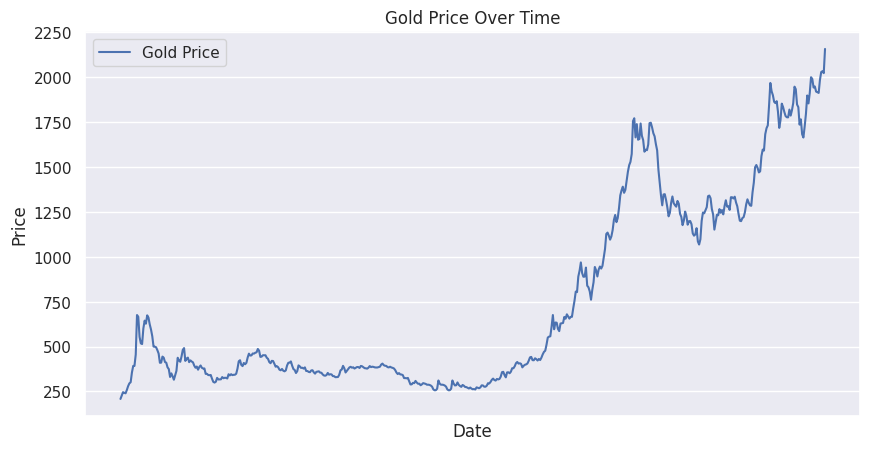

In [246]:
plt.figure(figsize=(10, 5))
plt.plot(gold_price['Date'], gold_price['Price'], label='Gold Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

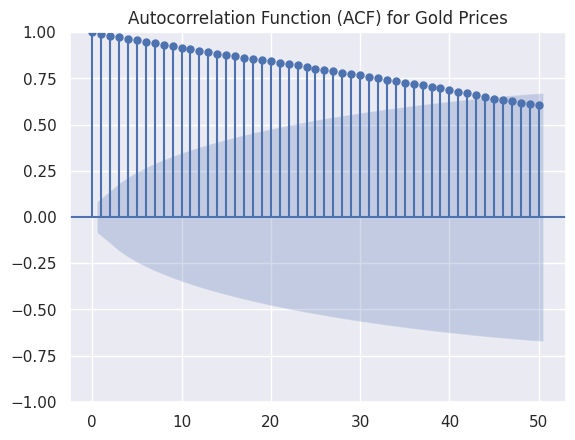

In [247]:
plot_acf(gold_price['Price'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for Gold Prices')
plt.show()

ACF Plot - Steadily Decreasing Bars:

This pattern indicates a non-stationary time series. It suggests that future values of the series are correlated / heavily affected by past values.

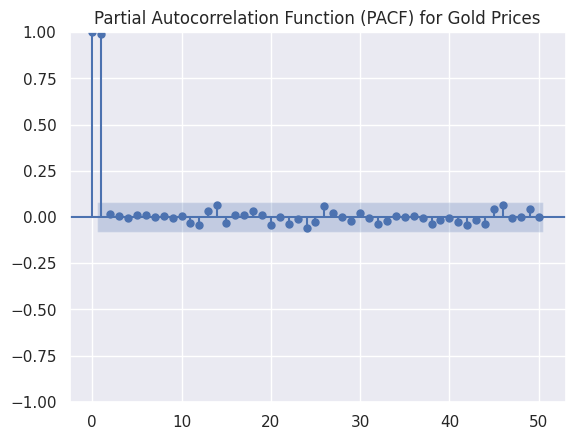

In [248]:
plot_pacf(gold_price['Price'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for Gold Prices')
plt.show()

PACF Plot - Bars Exceeding the Significance Boundary:

Significant spikes in the PACF plot that exceed the confidence interval boundaries indicate potential lags that could be used as terms in an AR model.

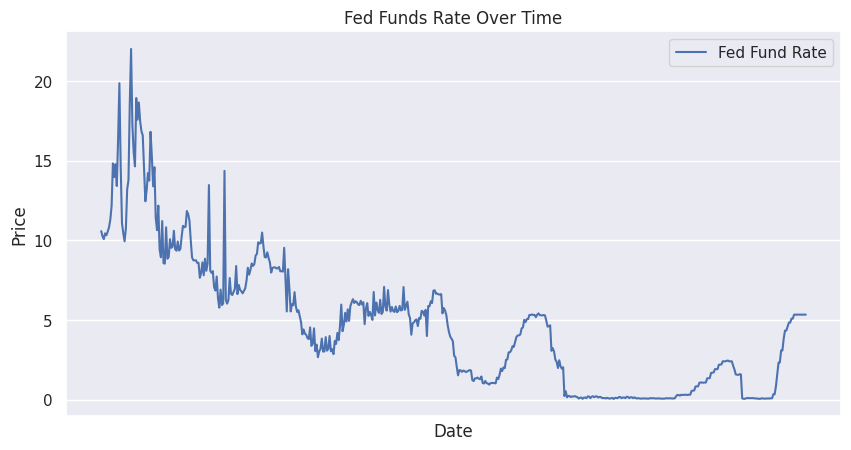

In [249]:
plt.figure(figsize=(10, 5))
plt.plot(fed_funds_rate['Date'], fed_funds_rate['Price'], label='Fed Fund Rate')
plt.title('Fed Funds Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

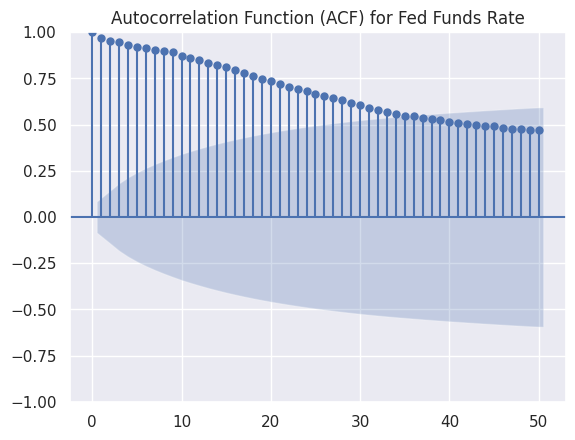

In [250]:
plot_acf(fed_funds_rate['Price'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for Fed Funds Rate')
plt.show()

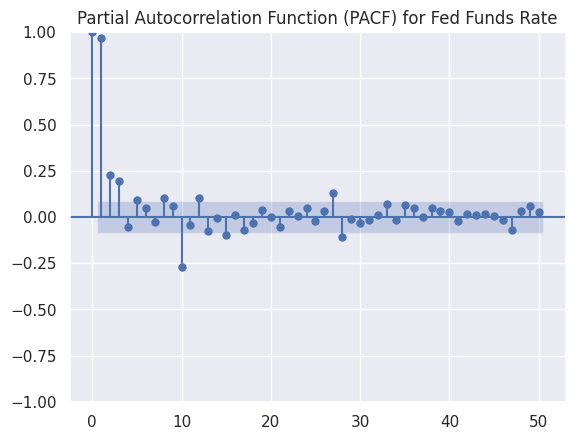

In [251]:
plot_pacf(fed_funds_rate['Price'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for Fed Funds Rate')
plt.show()

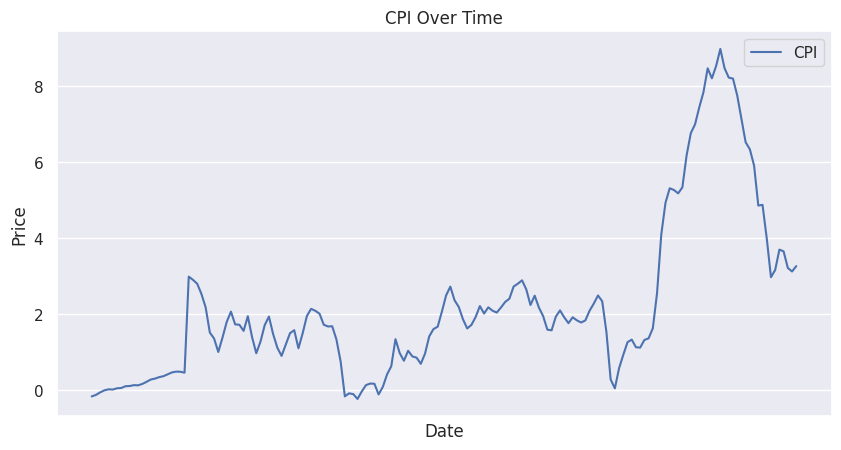

In [252]:
plt.figure(figsize=(10, 5))
plt.plot(CPI['Date'], CPI['Price'], label='CPI')
plt.title('CPI Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

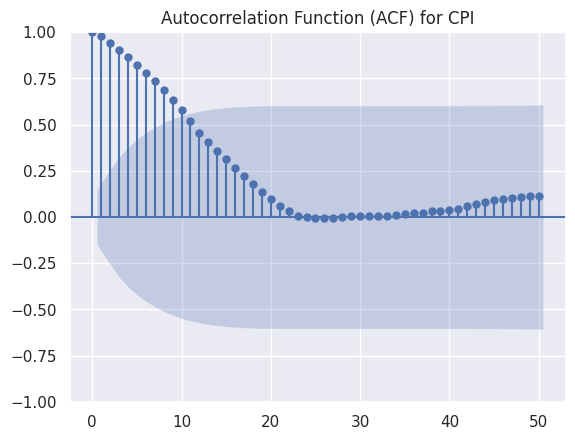

In [253]:
plot_acf(CPI['Price'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for CPI')
plt.show()

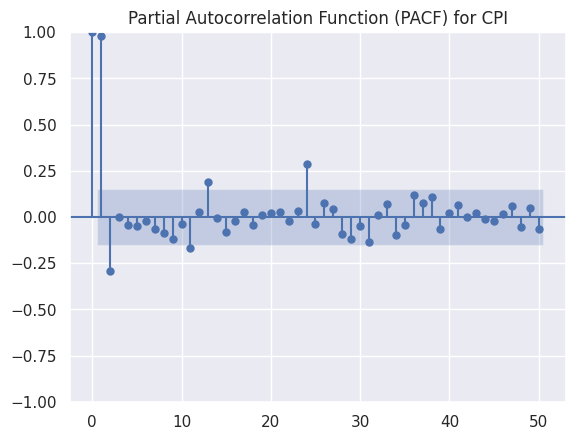

In [254]:
plot_pacf(CPI['Price'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for CPI')
plt.show()

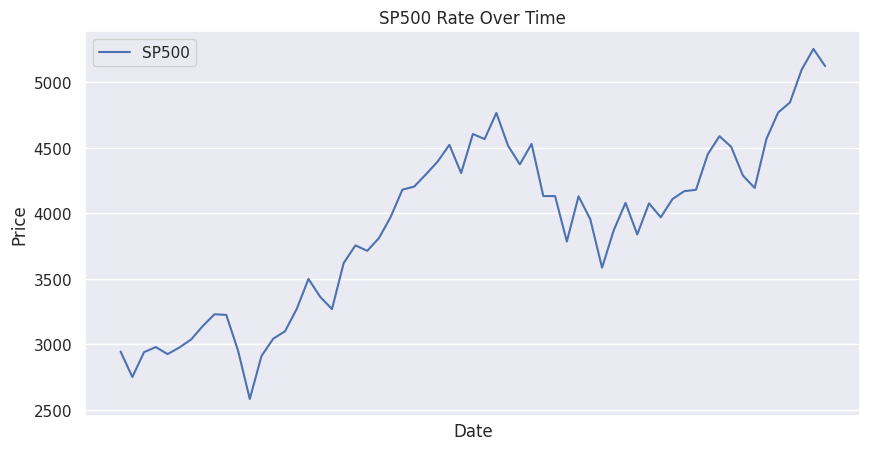

In [255]:
plt.figure(figsize=(10, 5))
plt.plot(SP500['Date'], SP500['Price'], label='SP500')
plt.title('SP500 Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

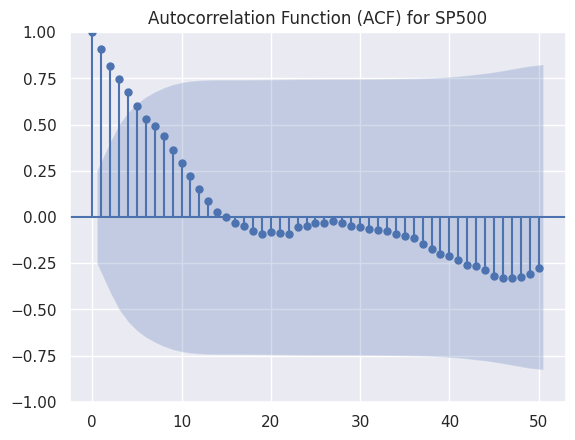

In [256]:
plot_acf(SP500['Price'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for SP500')
plt.show()

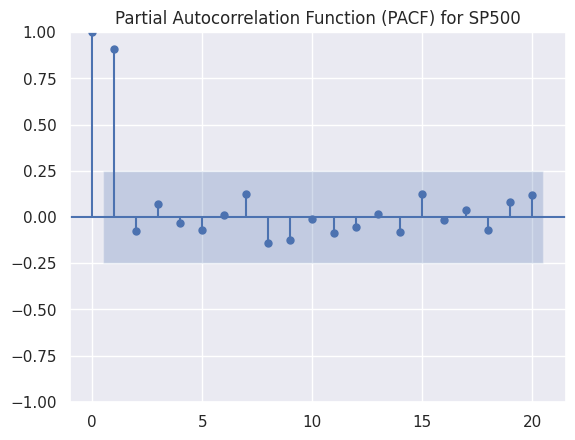

In [257]:
plot_pacf(SP500['Price'], lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for SP500')
plt.show()

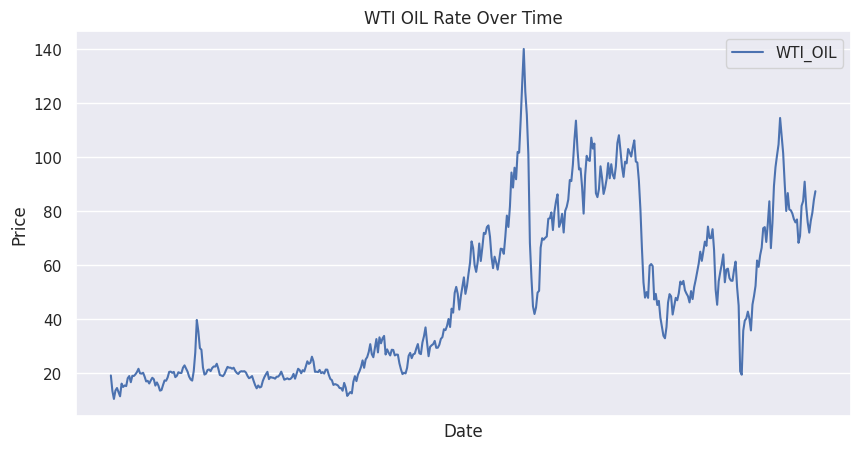

In [258]:
plt.figure(figsize=(10, 5))
plt.plot(WTI_OIL['Date'], WTI_OIL['Price'], label='WTI_OIL')
plt.title('WTI OIL Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

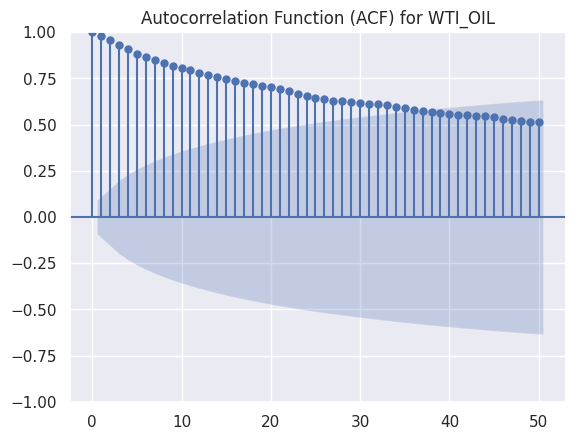

In [259]:
plot_acf(WTI_OIL['Price'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for WTI_OIL')
plt.show()

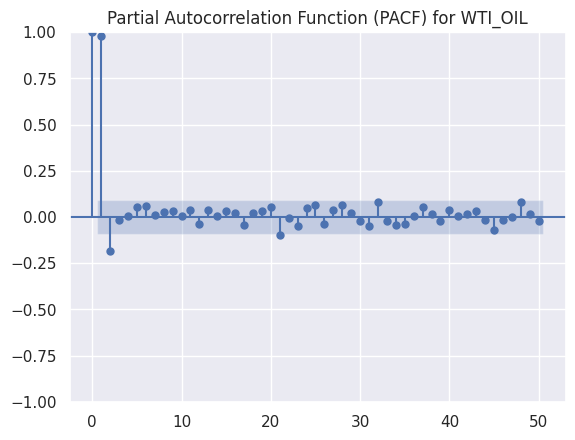

In [260]:
plot_pacf(WTI_OIL['Price'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for WTI_OIL')
plt.show()

## Data processing (anomaly detection, cleansing and imputations) and transformations

In [261]:
gold_price['Date'] = pd.to_datetime(gold_price['Date'])
gold_price.set_index('Date', inplace=True)
gold_price_sliced = gold_price.loc['2019-04-30':'2023-11-30']

In [262]:
fed_funds_rate['Date'] = pd.to_datetime(fed_funds_rate['Date'])
fed_funds_rate.set_index('Date', inplace=True)
fed_funds_rate_sliced = fed_funds_rate.loc['2019-04-30':'2023-11-30']

In [263]:
CPI['Date'] = pd.to_datetime(CPI['Date'])
CPI.set_index('Date', inplace=True)
CPI_sliced = CPI.loc['2019-04-30':'2023-11-30']

In [264]:
SP500['Date'] = pd.to_datetime(SP500['Date'])
SP500.set_index('Date', inplace=True)
SP500_sliced = SP500.loc['2019-04-30':'2023-11-30']

In [265]:
WTI_OIL['Date'] = pd.to_datetime(WTI_OIL['Date'])
WTI_OIL.set_index('Date', inplace=True)
WTI_OIL_sliced = WTI_OIL.loc['2019-04-30':'2023-11-30']

In [266]:
print(len(gold_price_sliced))
print(len(fed_funds_rate_sliced))
print(len(CPI_sliced))
print(len(SP500_sliced))
print(len(WTI_OIL_sliced))

56
56
56
56
56


In [267]:
combined_df = pd.concat([gold_price_sliced, fed_funds_rate_sliced, CPI_sliced, SP500_sliced, WTI_OIL_sliced], axis=1)

combined_df.columns = ['Gold_Price', 'Fed_Funds_Rate', 'CPI', 'SP500', 'WTI_OIL']

In [268]:
combined_df.head()

,Gold_Price,Fed_Funds_Rate,CPI,SP500,WTI_OIL
Date,,,,,
2019-04-30,1286.45,2.45,2.099331,2945.83,63.83
2019-05-31,1283.95,2.40,1.916335,2752.06,53.49
2019-06-28,1359.04,NaN,NaN,NaN,NaN
2019-06-30,NaN,2.40,1.764365,2941.76,58.20
2019-07-31,1412.98,2.40,1.917843,2980.38,58.53


In [269]:
# Check for Missing Values
print(combined_df.isnull().sum())

Gold_Price        15
Fed_Funds_Rate    15
CPI               15
SP500             15
WTI_OIL           15
dtype: int64


In [270]:
# using fill, may change later
combined_df.fillna(method='bfill', inplace=True)

In [271]:
combined_df

,Gold_Price,Fed_Funds_Rate,CPI,SP500,WTI_OIL
Date,,,,,
2019-04-30,1286.45,2.45,2.099331,2945.83,63.83
2019-05-31,1283.95,2.40,1.916335,2752.06,53.49
2019-06-28,1359.04,2.40,1.764365,2941.76,58.20
2019-06-30,1412.98,2.40,1.764365,2941.76,58.20
2019-07-31,1412.98,2.40,1.917843,2980.38,58.53
...,...,...,...,...,...
2023-08-31,1920.03,5.33,3.696583,4507.66,83.55
2023-09-29,1916.96,5.33,3.650365,4288.05,90.77
2023-09-30,1913.04,5.33,3.650365,4288.05,90.77


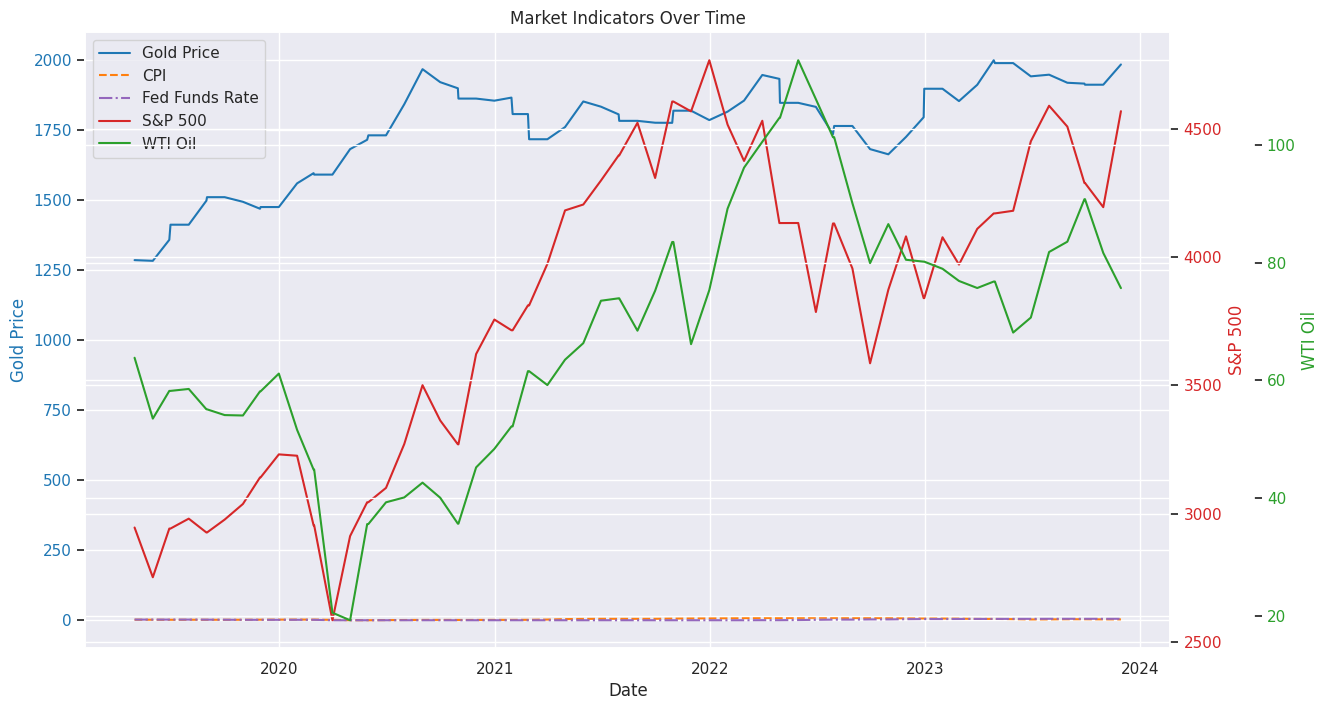

In [272]:
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price', color=color)
ax1.plot(combined_df.index, combined_df['Gold_Price'], color=color, label='Gold Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('S&P 500', color=color)
ax2.plot(combined_df.index, combined_df['SP500'], color=color, label='S&P 500')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('WTI Oil', color=color)
ax3.plot(combined_df.index, combined_df['WTI_OIL'], color=color, label='WTI Oil')
ax3.tick_params(axis='y', labelcolor=color)

ax1.plot(combined_df.index, combined_df['CPI'], color='tab:orange', linestyle='--', label='CPI')
ax1.plot(combined_df.index, combined_df['Fed_Funds_Rate'], color='tab:purple', linestyle='-.', label='Fed Funds Rate')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

plt.title('Market Indicators Over Time')
plt.show()


                Gold_Price  Fed_Funds_Rate       CPI     SP500   WTI_OIL
Gold_Price        1.000000        0.152112  0.330900  0.716368  0.345616
Fed_Funds_Rate    0.152112        1.000000  0.143392  0.177329  0.346727
CPI               0.330900        0.143392  1.000000  0.661722  0.878530
SP500             0.716368        0.177329  0.661722  1.000000  0.712973
WTI_OIL           0.345616        0.346727  0.878530  0.712973  1.000000


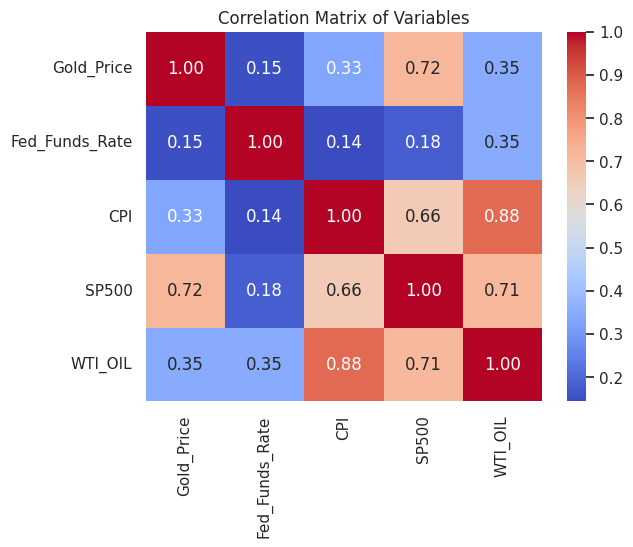

In [273]:
correlation_matrix = combined_df.corr()

print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()


### Check for Stationarity

In [274]:
combined_df.head()

,Gold_Price,Fed_Funds_Rate,CPI,SP500,WTI_OIL
Date,,,,,
2019-04-30,1286.45,2.45,2.099331,2945.83,63.83
2019-05-31,1283.95,2.40,1.916335,2752.06,53.49
2019-06-28,1359.04,2.40,1.764365,2941.76,58.20
2019-06-30,1412.98,2.40,1.764365,2941.76,58.20
2019-07-31,1412.98,2.40,1.917843,2980.38,58.53


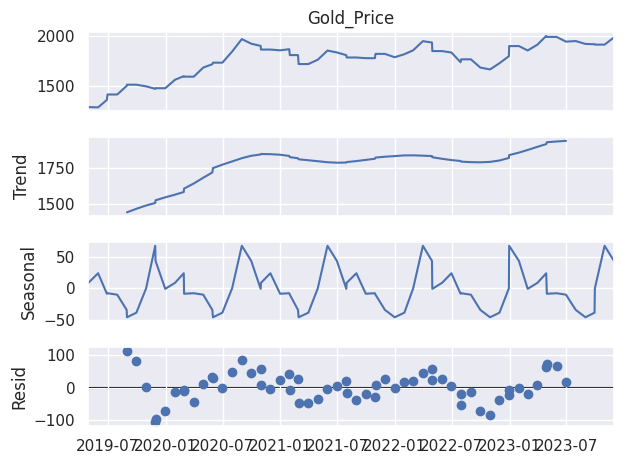

In [275]:
result = seasonal_decompose(combined_df['Gold_Price'], model='additive', period=12)
result.plot()
plt.show()

Clearly see seasonality here.

In [276]:
print("Check for Gold Stationarity")
result = adfuller(combined_df['Gold_Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# p-value is greater than 0.05, we need to difference the data.

Check for Gold Stationarity
ADF Statistic: -2.181414
p-value: 0.213060
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


In [277]:
# Applying logarithmic transformation
combined_df['Gold_Price_Log'] = np.log(combined_df['Gold_Price'])

result_log = adfuller(combined_df['Gold_Price_Log'])
print('ADF Statistic: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
    print('\t%s: %.3f' % (key, value))

# Not working good

ADF Statistic: -2.405566
p-value: 0.140171
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


In [278]:
combined_df['Gold_Price_diff'] = combined_df['Gold_Price'].diff().dropna()

In [279]:
selected_rows = combined_df.iloc[1:]
print("Check for Gold Stationarity after differencing")
result = adfuller(selected_rows['Gold_Price_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for Gold Stationarity after differencing
ADF Statistic: -6.201727
p-value: 0.000000
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


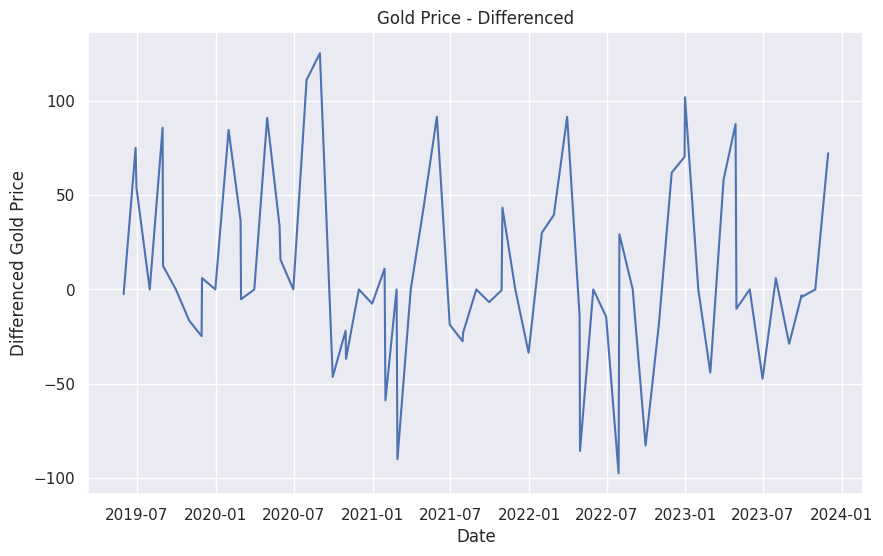

In [280]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['Gold_Price_diff'])
plt.title('Gold Price - Differenced')
plt.xlabel('Date')
plt.ylabel('Differenced Gold Price')
plt.show()

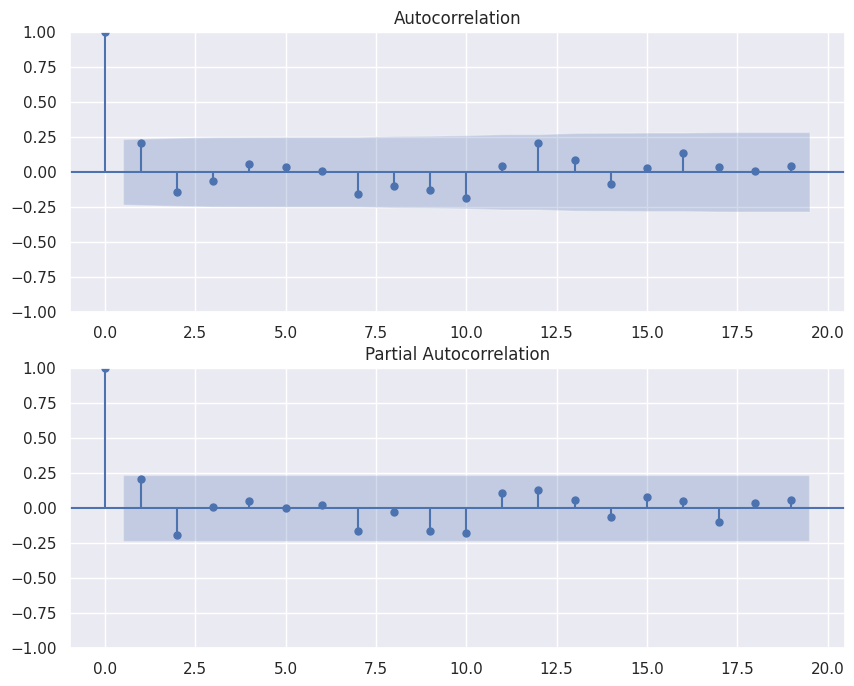

In [281]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(combined_df['Gold_Price_diff'].dropna(), ax=ax[0])
plot_pacf(combined_df['Gold_Price_diff'].dropna(), ax=ax[1])
plt.show()

In [282]:
print("Check for Fed Funds Stationarity")
result = adfuller(combined_df['Fed_Funds_Rate'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for Fed Funds Stationarity
ADF Statistic: 0.296188
p-value: 0.977169
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


In [283]:
# Applying logarithmic transformation
combined_df['Fed_Funds_Rate_Log'] = np.log(combined_df['Fed_Funds_Rate'])

result_log = adfuller(combined_df['Fed_Funds_Rate_Log'])
print('ADF Statistic: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.992304
p-value: 0.756061
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


In [284]:
combined_df['Fed_Funds_Rate_diff'] = combined_df['Fed_Funds_Rate'].diff().dropna()

In [285]:
selected_rows = combined_df.iloc[1:]
print("Check for Fed_Funds_Rate Stationarity after differencing")
result = adfuller(selected_rows['Fed_Funds_Rate_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for Fed_Funds_Rate Stationarity after differencing
ADF Statistic: -6.315456
p-value: 0.000000
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


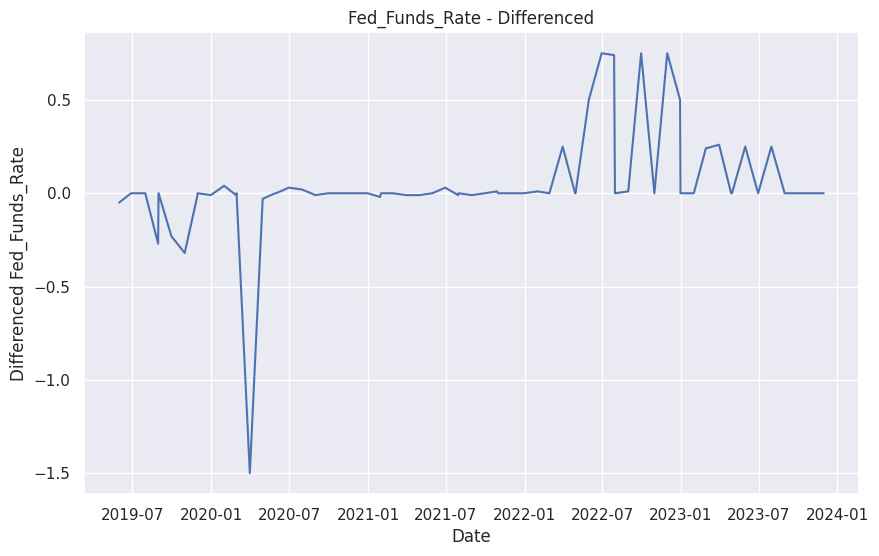

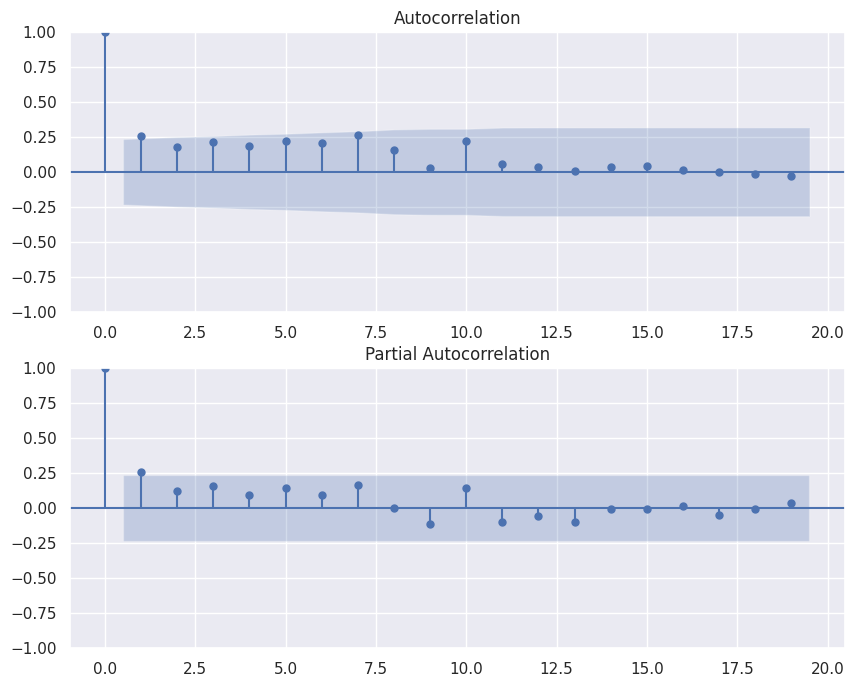

In [286]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['Fed_Funds_Rate_diff'])
plt.title('Fed_Funds_Rate - Differenced')
plt.xlabel('Date')
plt.ylabel('Differenced Fed_Funds_Rate')
plt.show()

fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(combined_df['Fed_Funds_Rate_diff'].dropna(), ax=ax[0])
plot_pacf(combined_df['Fed_Funds_Rate_diff'].dropna(), ax=ax[1])
plt.show()

In [287]:
print("Check for CPI Stationarity")
result = adfuller(combined_df['CPI'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for CPI Stationarity
ADF Statistic: -1.347080
p-value: 0.607368
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


In [288]:
combined_df['CPI_diff'] = combined_df['CPI'].diff().dropna()

In [289]:
selected_rows = combined_df.iloc[1:]
print("Check for CPI Stationarity after differencing")
result = adfuller(selected_rows['CPI_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for CPI Stationarity after differencing
ADF Statistic: -4.746561
p-value: 0.000069
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


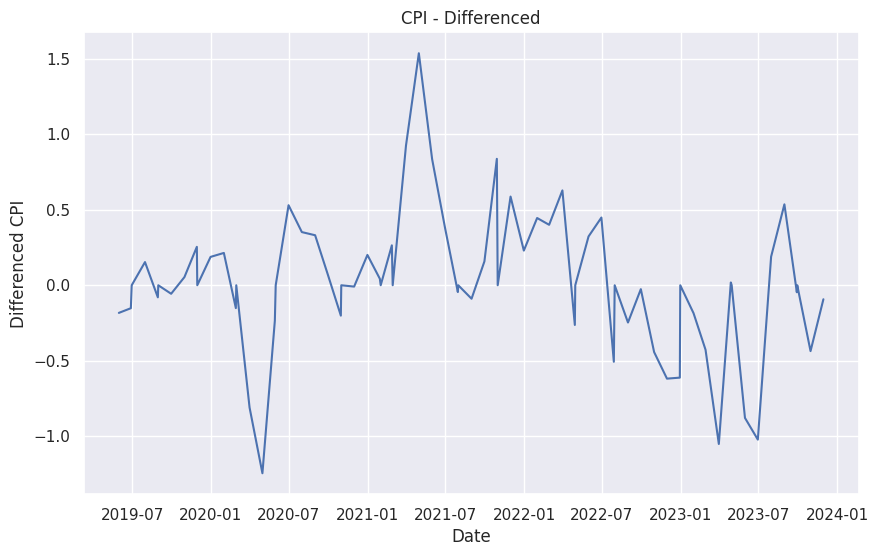

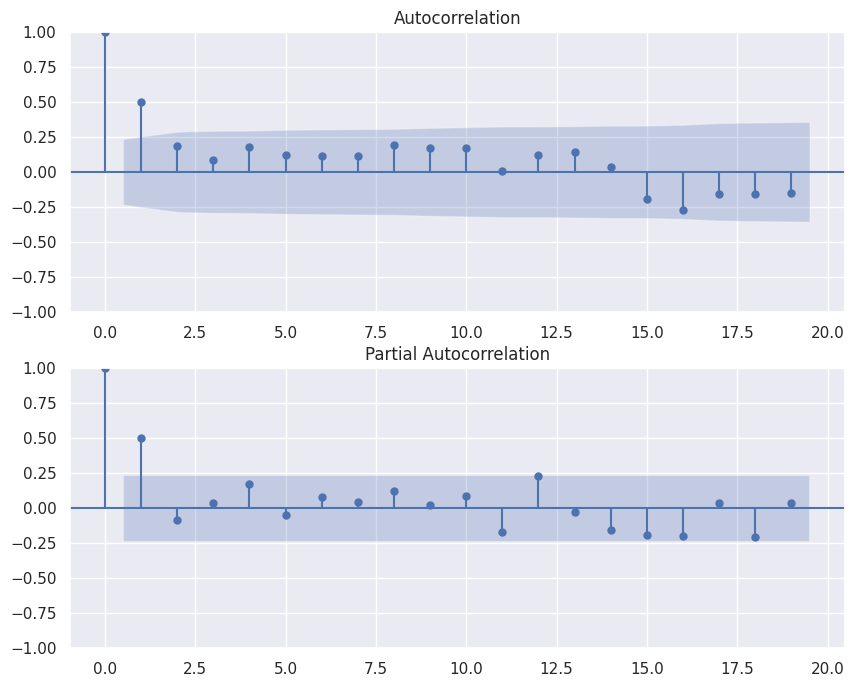

In [290]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['CPI_diff'])
plt.title('CPI - Differenced')
plt.xlabel('Date')
plt.ylabel('Differenced CPI')
plt.show()

fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(combined_df['CPI_diff'].dropna(), ax=ax[0])
plot_pacf(combined_df['CPI_diff'].dropna(), ax=ax[1])
plt.show()

In [291]:
print("Check for SP500 Stationarity")
result = adfuller(combined_df['SP500'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for SP500 Stationarity
ADF Statistic: -1.288785
p-value: 0.634288
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589


In [292]:
# Applying logarithmic transformation
combined_df['SP500_Log'] = np.log(combined_df['SP500'])

result_log = adfuller(combined_df['SP500_Log'])
print('ADF Statistic: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.350328
p-value: 0.605844
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589


In [293]:
combined_df['SP500_diff'] = combined_df['SP500'].diff().dropna()
selected_rows = combined_df.iloc[1:]
print("Check for SP500 Stationarity after differencing")
result = adfuller(selected_rows['SP500_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for SP500 Stationarity after differencing
ADF Statistic: -7.283266
p-value: 0.000000
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


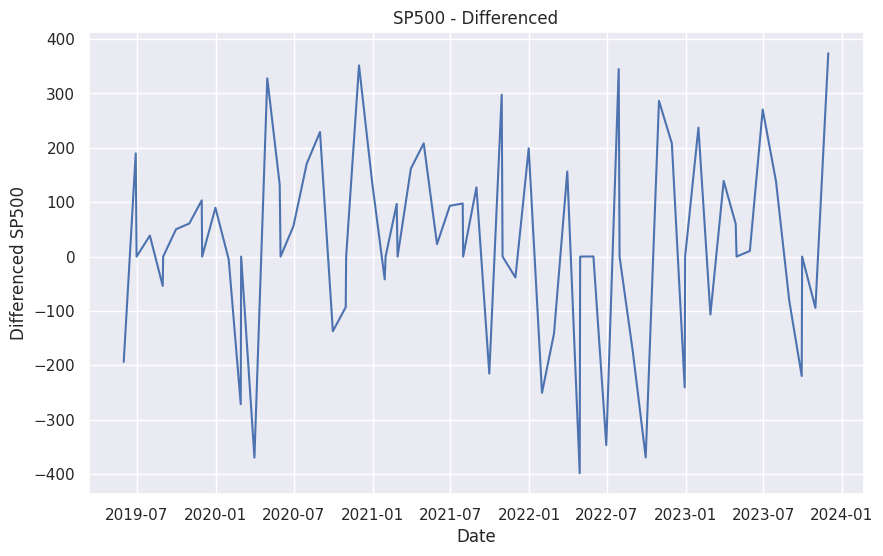

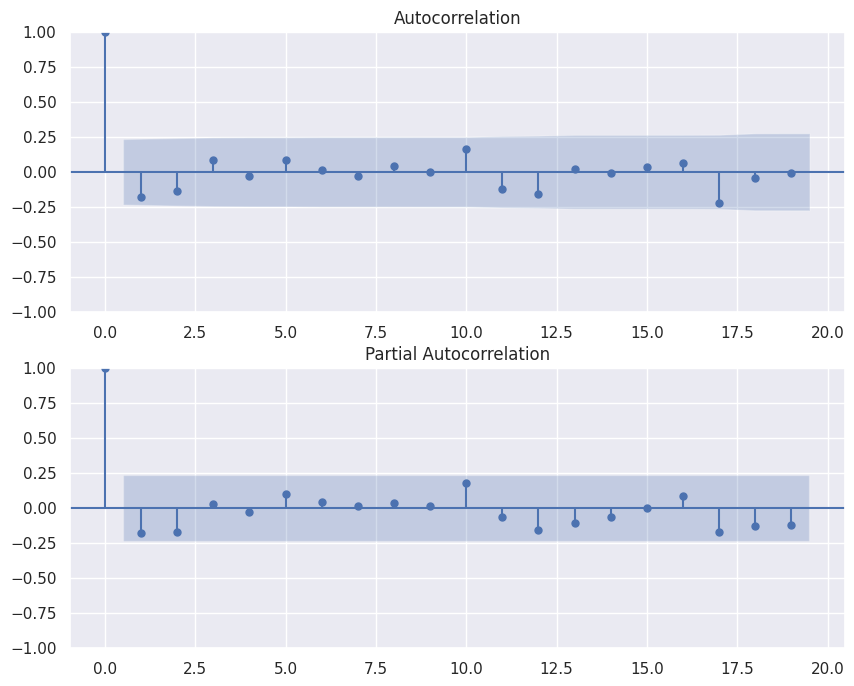

In [294]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['SP500_diff'])
plt.title('SP500 - Differenced')
plt.xlabel('Date')
plt.ylabel('Differenced SP500')
plt.show()

fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(combined_df['SP500_diff'].dropna(), ax=ax[0])
plot_pacf(combined_df['SP500_diff'].dropna(), ax=ax[1])
plt.show()

In [295]:
print("Check for WTI_OIL Stationarity")
result = adfuller(combined_df['WTI_OIL'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for WTI_OIL Stationarity
ADF Statistic: -1.308917
p-value: 0.625083
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589


In [296]:
combined_df['WTI_OIL_diff'] = combined_df['WTI_OIL'].diff().dropna()
selected_rows = combined_df.iloc[1:]
print("Check for WTI_OIL Stationarity after differencing")
result = adfuller(selected_rows['WTI_OIL_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Check for WTI_OIL Stationarity after differencing
ADF Statistic: -6.306747
p-value: 0.000000
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


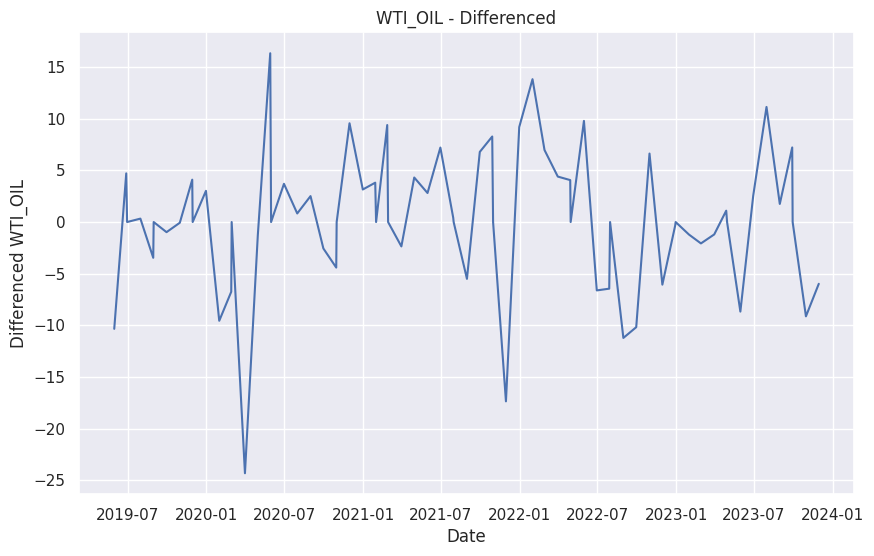

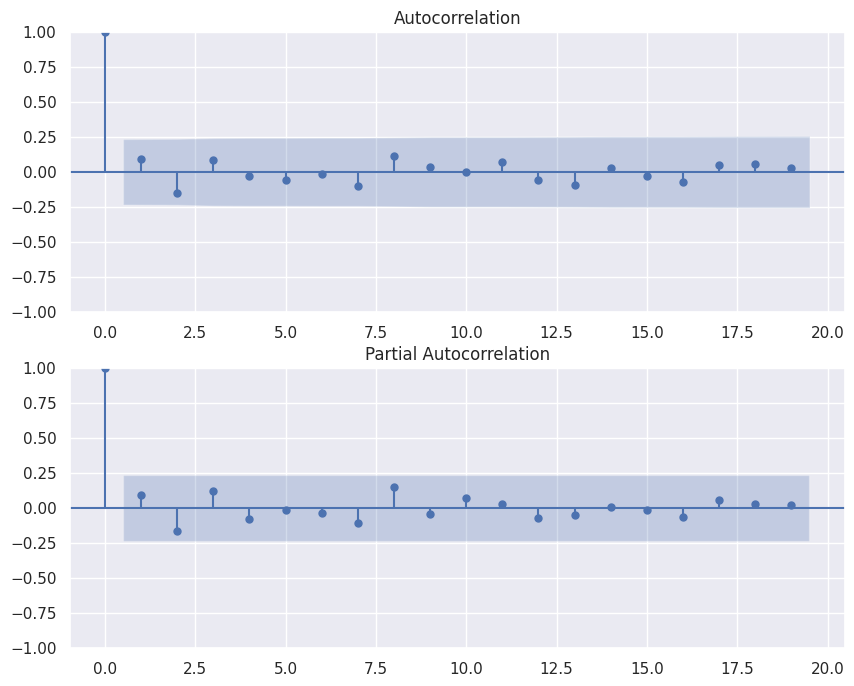

In [297]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['WTI_OIL_diff'])
plt.title('WTI_OIL - Differenced')
plt.xlabel('Date')
plt.ylabel('Differenced WTI_OIL')
plt.show()

fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(combined_df['WTI_OIL_diff'].dropna(), ax=ax[0])
plot_pacf(combined_df['WTI_OIL_diff'].dropna(), ax=ax[1])
plt.show()

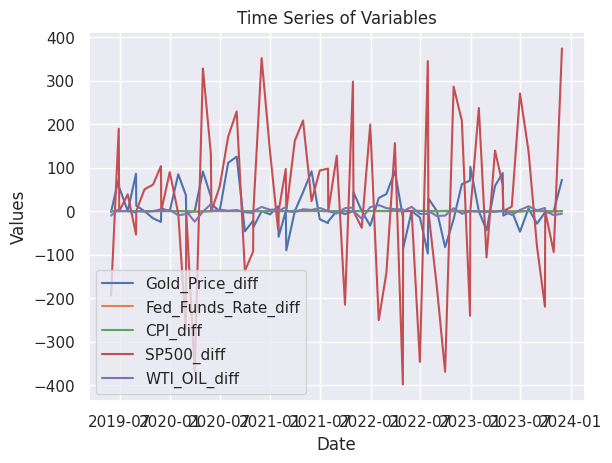

In [298]:
plt.plot(combined_df['Gold_Price_diff'], label='Gold_Price_diff')
plt.plot(combined_df['Fed_Funds_Rate_diff'], label='Fed_Funds_Rate_diff')
plt.plot(combined_df['CPI_diff'], label='CPI_diff')
plt.plot(combined_df['SP500_diff'], label='SP500_diff')
plt.plot(combined_df['WTI_OIL_diff'], label='WTI_OIL_diff')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Variables')
plt.legend()

# Show the plot
plt.show()

## Feature engineering

#### ARIMAX

In [299]:
combined_df_diff = combined_df[["Gold_Price_diff", "Fed_Funds_Rate_diff", "CPI_diff", "SP500_diff", "WTI_OIL_diff"]]
combined_df_forARIMA = combined_df_diff.iloc[1:-10]
combined_df_forARIMA.head()

,Gold_Price_diff,Fed_Funds_Rate_diff,CPI_diff,SP500_diff,WTI_OIL_diff
Date,,,,,
2019-05-31,-2.50,-0.05,-0.182996,-193.77,-10.34
2019-06-28,75.09,0.00,-0.151970,189.70,4.71
2019-06-30,53.94,0.00,0.000000,0.00,0.00
2019-07-31,0.00,0.00,0.153478,38.62,0.33
2019-08-30,85.82,-0.27,-0.080001,-53.92,-3.46


In [300]:
combined_df_forARIMA.index = pd.to_datetime(combined_df_forARIMA.index)

In [301]:
y = combined_df_forARIMA['Gold_Price_diff']
X = combined_df_forARIMA[['Fed_Funds_Rate_diff', 'CPI_diff', 'SP500_diff', 'WTI_OIL_diff']]

model = pm.auto_arima(y, exogenous=X, seasonal= False, stepwise=False, suppress_warnings=True,
                      error_action="ignore", max_order=None, trace=True)
print(model.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=643.479, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=640.907, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=642.558, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=644.299, Time=0.13 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=644.736, Time=0.23 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=645.845, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=642.132, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=642.676, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=644.488, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=643.942, Time=0.35 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=644.706, Time=0.40 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=646.653, Time=0.64 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=642.409, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=644.274, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(2,0,3)(0,0,0)[0]      

The PACF value is 0 i.e. p=0
,this means that the lags in PACF graph are not significant and this is interpreted as trend component of the time series is not playing a significant role.


d=0
This means that the Time series provided is stationary and does not require differencing.


q=1
The ACF value is 1. Which means that the lag after which the ACF value becomes zero in the graph is 1. (excluding the first lag, which is correlation of our target variable with itself). This means that our time series has a randomness component and the ACF after the lag 2 becomes 0. This is because the first spike in ACF plot is because of the correlation of the variable with itself(as I have mentioned before)

The large p-value confirms that the residuals are similar to white noise.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


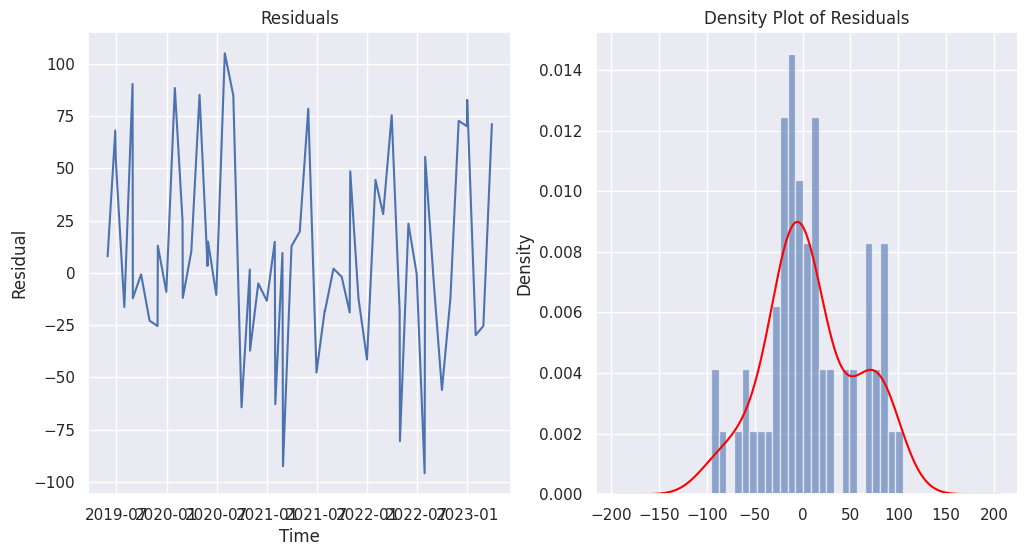

In [302]:
model = SARIMAX(y, exog=X, order=(0, 0, 1), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# Plot residuals
residuals = results.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(residuals)
ax[0].set_title('Residuals')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Residual')

# Histogram plus estimated density
ax[1].hist(residuals, bins=25, density=True, alpha=0.6, color='b')
residuals.plot(kind='kde', ax=ax[1], color='red')
ax[1].set_title('Density Plot of Residuals')

plt.show()

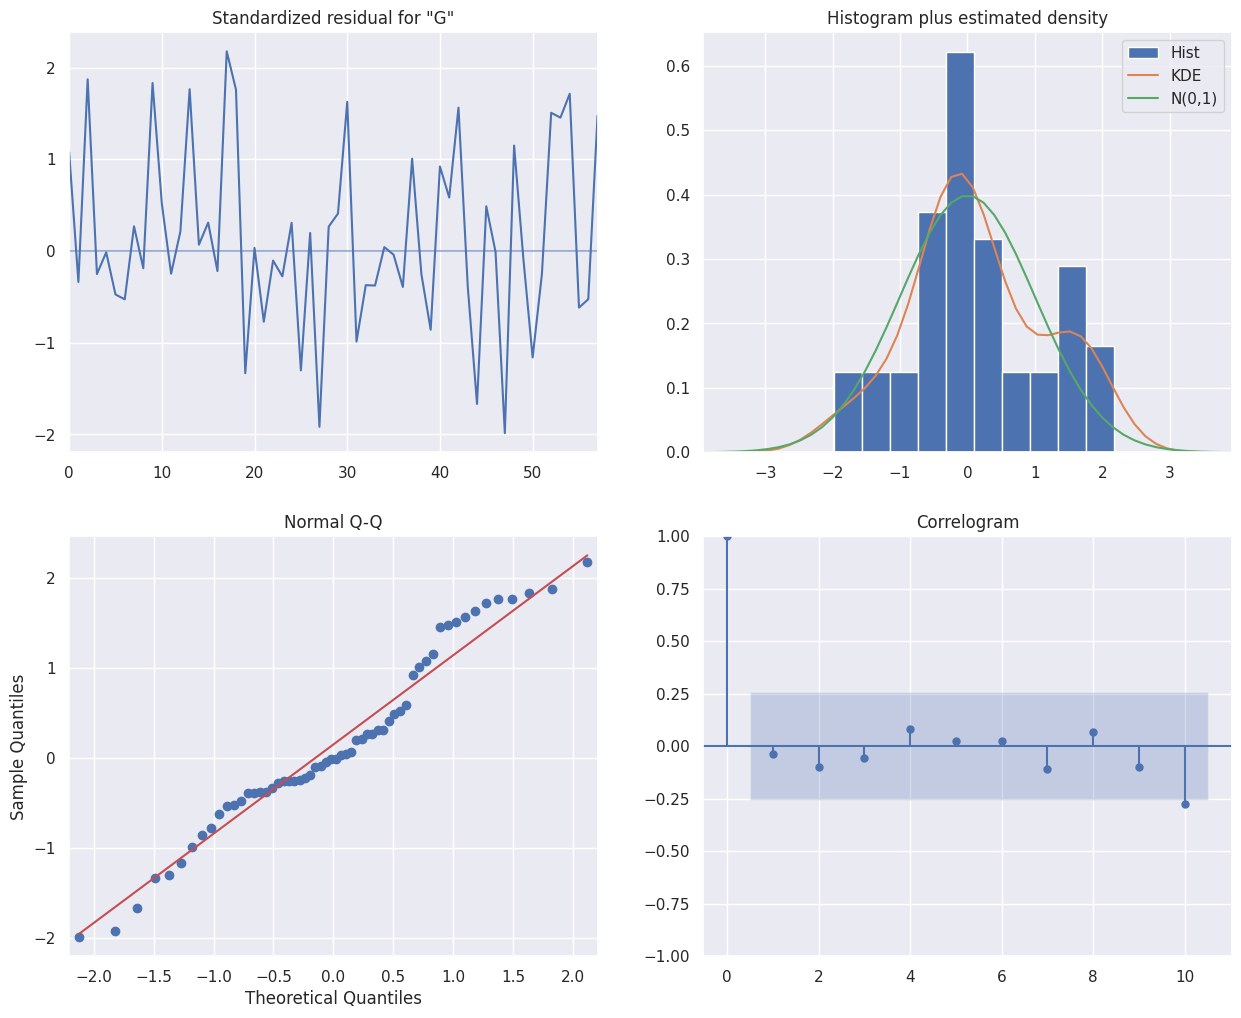

In [303]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Results (accuracy) and learnings from the methodology

In [304]:
df_forTest = combined_df.tail(10)[["Fed_Funds_Rate_diff", "CPI_diff", "SP500_diff", "WTI_OIL_diff"]]

In [305]:
X_future = df_forTest

forecast = results.get_forecast(steps=10, exog=X_future)
print(forecast.summary_frame())

Gold_Price_diff       mean    mean_se  mean_ci_lower  mean_ci_upper
60               22.081186  48.270977     -72.528190     116.690563
61                0.000000  50.039668     -98.075947      98.075947
62              -11.168613  50.039668    -109.244561      86.907334
63                3.103604  50.039668     -94.972343     101.179551
64                6.046760  50.039668     -92.029187     104.122707
65                1.336565  50.039668     -96.739382      99.412512
66               -6.896291  50.039668    -104.972239      91.179656
67                0.000000  50.039668     -98.075947      98.075947
68               -8.831839  50.039668    -106.907786      89.244108
69               11.912440  50.039668     -86.163507     109.988387


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [306]:
combined_df['Gold_Price'].iloc[-11]

1912.73

In [307]:
last_gold_price = combined_df['Gold_Price'].iloc[-11]

forecast.predicted_mean = pd.DataFrame(forecast.predicted_mean)
predicted_gold_price = forecast.predicted_mean.cumsum() + last_gold_price
predicted_gold_price

,predicted_mean
60,1934.811186
61,1934.811186
62,1923.642573
63,1926.746177
64,1932.792937
65,1934.129502
66,1927.233210
67,1927.233210
68,1918.401371
69,1930.313811


In [308]:
predicted_gold_price = pd.DataFrame(predicted_gold_price)

dates = [
    '2023-04-28', '2023-04-30', '2023-05-31',
    '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-29',
    '2023-09-30', '2023-10-31', '2023-11-30'
]

predicted_gold_price['date'] = pd.to_datetime(dates)

predicted_gold_price.set_index('date', inplace=True)

print(predicted_gold_price)

            predicted_mean
date                      
2023-04-28     1934.811186
2023-04-30     1934.811186
2023-05-31     1923.642573
2023-06-30     1926.746177
2023-07-31     1932.792937
2023-08-31     1934.129502
2023-09-29     1927.233210
2023-09-30     1927.233210
2023-10-31     1918.401371
2023-11-30     1930.313811


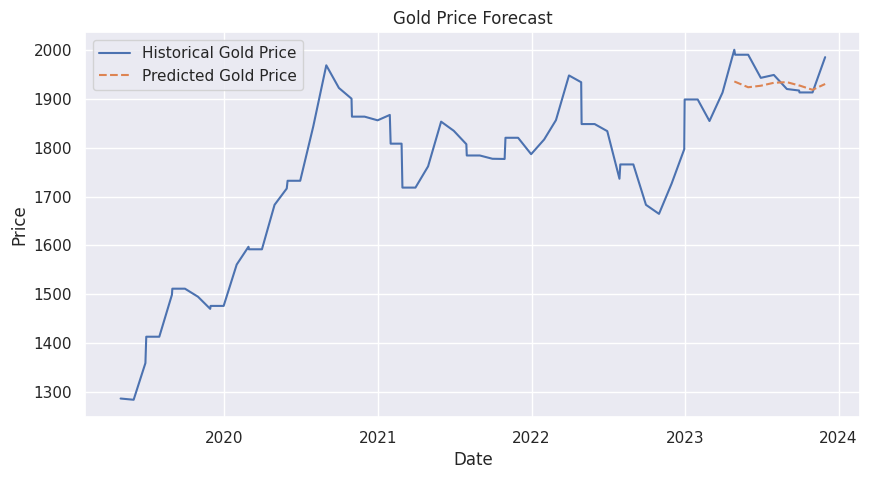

In [309]:
plt.figure(figsize=(10, 5))
plt.plot(gold_prices.index, gold_prices, label='Historical Gold Price')
plt.plot(predicted_gold_price.index, predicted_gold_price, label='Predicted Gold Price', linestyle='--')
plt.title('Gold Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Future work

## Data Sources

“Gold Spot Price and Cost of Gold.” World Gold Council, www.gold.org/goldhub/data/gold-prices

“Federal Funds Effective Rate.” FRED, fred.stlouisfed.org/series/DFF

“NBER Based Recession Indicators for the United States from the Period Following the Peak through the Trough.” FRED, fred.stlouisfed.org/series/USREC

“S&P 500.” FRED, fred.stlouisfed.org/series/SP500.

“Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma.” FRED, fred.stlouisfed.org/series/DCOILWTICO.